In [2]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.7
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
# set this to your working directory
path = '' 
setwd(path)

# load the data
data <- read_csv('SonicYouthTunings.csv')

# remove songs that don't have any known tuning, where all strings are NA
data <- data[apply(data %>% select(matches('String')), 1, function(x) any(!is.na(x))),]

# the letters of each musical note
letters <- c('A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#')

# the tuning of E Standard, used as a baseline
eStandard <- c('E2', 'A3', 'D3', 'G3', 'B4', 'E4')

# create a vector with a possible guitar range of A1 to G#6
possibleRange <- paste(
    rep(letters, 6), 
    rep(1:6, each=length(letters)), 
    sep=''
)

# factor String6 so we can order
data <- data %>% 
    mutate(String6 = factor(String6, possibleRange))

# cut range so it starts from the lowest tuning we have data for
possibleRange <- possibleRange[-(1:match(sort(data$String6)[1], possibleRange)-1)] 

# factor possibleRange to preserve order
possibleRange <- factor(possibleRange, possibleRange)

Parsed with column specification:
cols(
  Name = col_character(),
  Album = col_character(),
  Song = col_character(),
  TrackNo = col_integer(),
  String6 = col_character(),
  String5 = col_character(),
  String4 = col_character(),
  String3 = col_character(),
  String2 = col_character(),
  String1 = col_character()
)


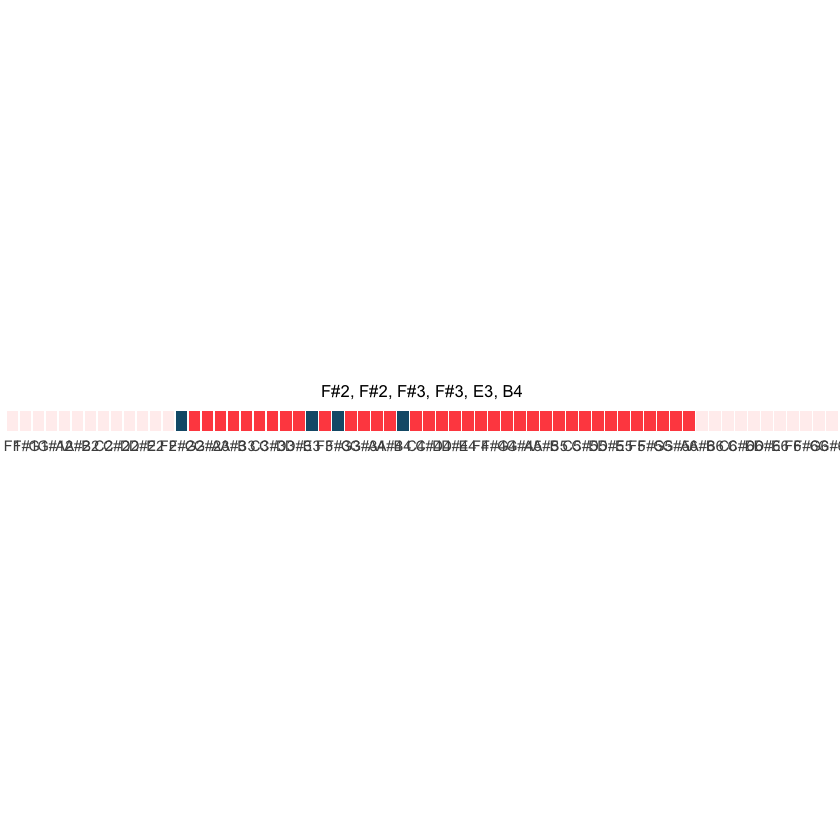

In [8]:
#######################################
# plot a bar chart of a single tuning #
#######################################

# the tuning to plot
singleTuningToPlot <- c('F#2', 'F#2', 'F#3', 'F#3', 'E3', 'B4')
# calculate range available with this tuning, assuming 22 fret guitars
availableRange <- possibleRange[match(singleTuningToPlot[1], possibleRange):(match(singleTuningToPlot[6], possibleRange) + 22)]

# make a tibble containing all the data
singleTuningData <- tibble(
    'Range' = possibleRange,
    'OpenString' = possibleRange %in% singleTuningToPlot,
    'AvailableRange' = possibleRange %in% availableRange
)

# plot the single tuning
singleTuningData %>% 
    ggplot(aes(Range, y=1, fill=OpenString, alpha=as.numeric(AvailableRange))) + 
    geom_bar(stat="identity") +
    scale_fill_manual(values=c("#ff5050", "#155b78")) +
    theme(axis.line=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          panel.background=element_blank(),
          panel.border=element_blank(),
          panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),
          plot.background=element_blank(),
          plot.margin=unit(c(0,0,0,0), "cm"),
          panel.spacing=unit(c(0,0,0,0), "cm"),
          legend.position='none',
          plot.title = element_text(hjust = 0.5, size=10)) +
    coord_fixed(ratio = 1.5) +
    ggtitle(paste(singleTuningToPlot, collapse=', '))

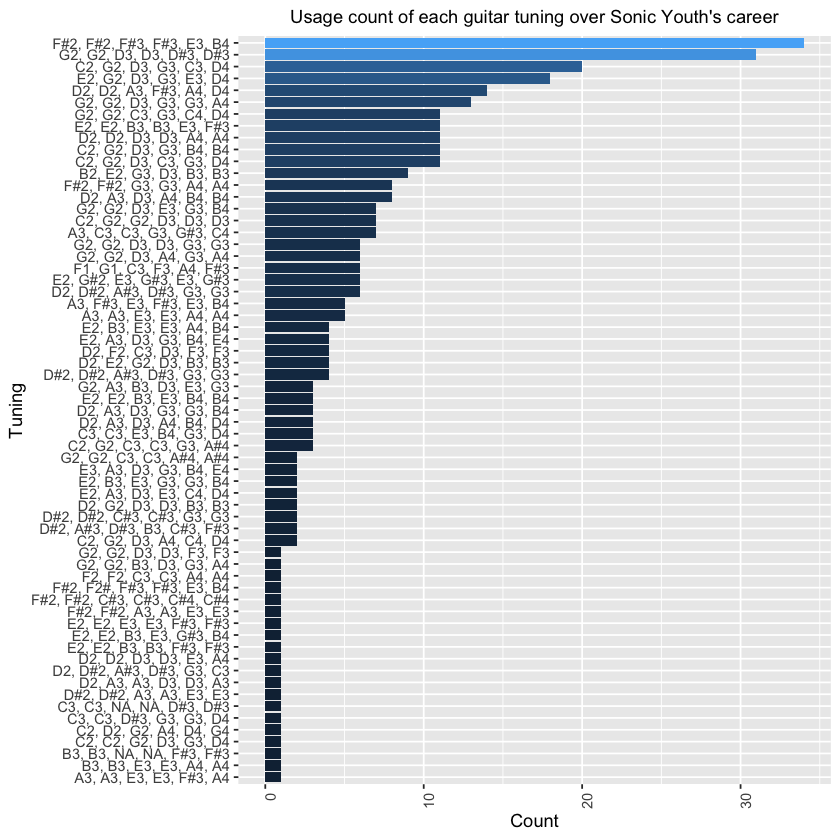

In [9]:
###########################
# plot the unique tunings #
###########################

# get the unique tunings
uniqueTunings <- unique(data %>% select(matches('String')))

# sort by lowest String6
uniqueTunings <- uniqueTunings %>% arrange(String6)

# make a tibble of all tunings by album
tuningsByAlbum <- tibble(
    'Album' = data$Album, 
    'Tuning' = as.list(as.tibble(t(data %>% select(matches('String')))))
)
# convert list of tunings to string
tuningsByAlbum$Tuning <- unlist(lapply(tuningsByAlbum$Tuning, function(x) toString(unlist(x, use.names = FALSE))))

# get a count of each tuning by album
tuningsCount = tuningsByAlbum %>% count(Tuning)

# plot bar chart of each tuning by album, ordered by most used
tuningsCount %>% ggplot(aes(reorder(Tuning, n), n, fill=n)) + 
    geom_bar(stat='Identity') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    xlab('Tuning') +
    ylab('Count') + 
    coord_flip() +
    theme(legend.position='none',
         plot.title = element_text(hjust = 0.5, size=11)) +
   ggtitle("Usage count of each guitar tuning over Sonic Youth's career")


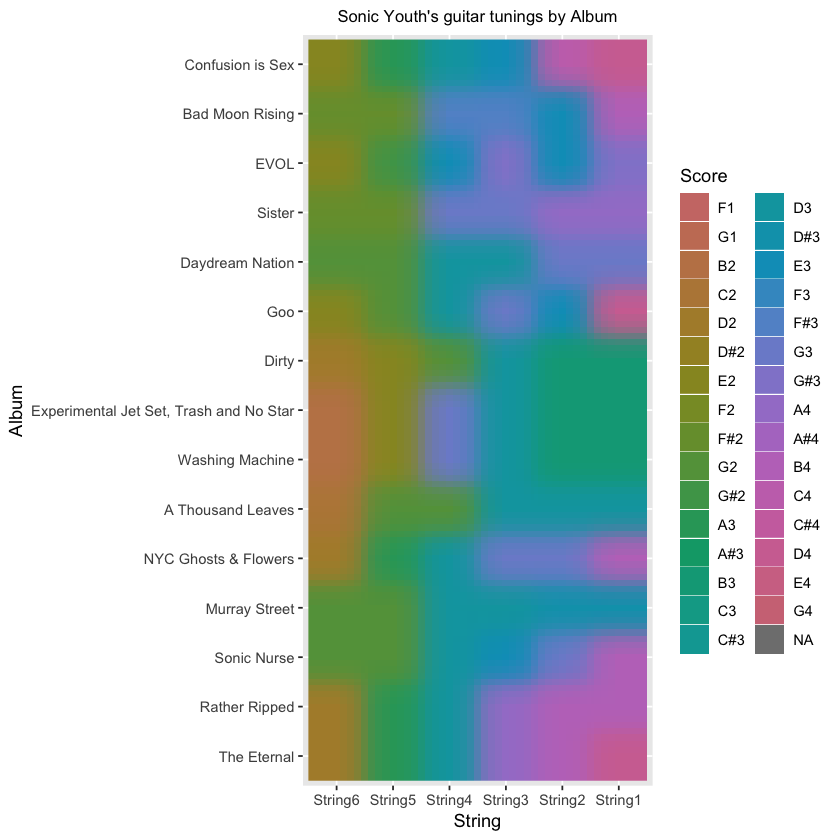

In [11]:
############################################
# colour map of tunings used by album/song #
############################################

strings  <- c('String6', 'String5', 'String4', 'String3', 'String2', 'String1')

# gather into long format, mutating string6 from factor to character
tuningsOverCareer <- data %>% 
    mutate('String6' = as.character(String6)) %>% 
    gather(strings, key=String, value=Tuning)

# factor string6 back again so we can sort
tuningsOverCareer$String <- factor(tuningsOverCareer$String, strings)

# factor possible range to preserve order
tuningsOverCareer$Tuning <- factor(tuningsOverCareer$Tuning, possibleRange)

# add tuning score
getTuningScore <- function(string, tuning) {
    
    # convert a factor to a string, substring it to get the number and convert to integer
    stringNo <- as.integer(substr(sapply(string, as.character), 7, 7))
    tuning <- sapply(tuning, as.character)
    
    tuningScore <- match(tuning, possibleRange) - match(rev(eStandard)[stringNo], possibleRange)
}
tuningsOverCareer <- tuningsOverCareer %>% 
    mutate('Score' = getTuningScore(tuningsOverCareer$String, tuningsOverCareer$Tuning))


# colour mapped to tuning by album (tuning)
tuningsOverCareer %>% 
    ggplot(aes(String, fct_rev(factor(Album, unique(data$Album))))) +
    geom_raster(aes(fill = factor(Tuning)), interpolate = TRUE) +
    scale_fill_hue(c=60,l=60, name = 'Score') +
    ylab('Album') +
    theme(plot.title = element_text(hjust = 0.5, size=10)) +
    ggtitle("Sonic Youth's guitar tunings by Album")

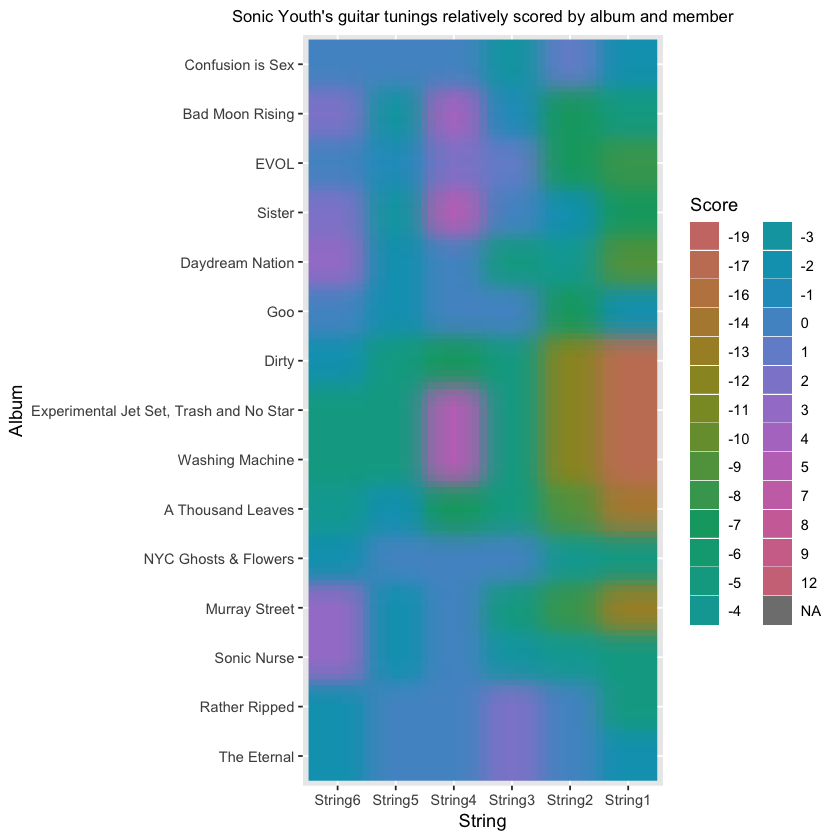

In [12]:
tuningsOverCareer %>% 
    ggplot(aes(String, fct_rev(factor(Album, unique(data$Album))))) +
    geom_raster(aes(fill = factor(Score)), interpolate = TRUE) +
    scale_fill_hue(c=60,l=60, name = 'Score') +
    ylab('Album') +
    theme(plot.title = element_text(hjust = 0.5, size=10)) +
    ggtitle("Sonic Youth's guitar tunings relatively scored by album and member")  # + facet_grid(. ~ Name) # uncomment this to facet by name

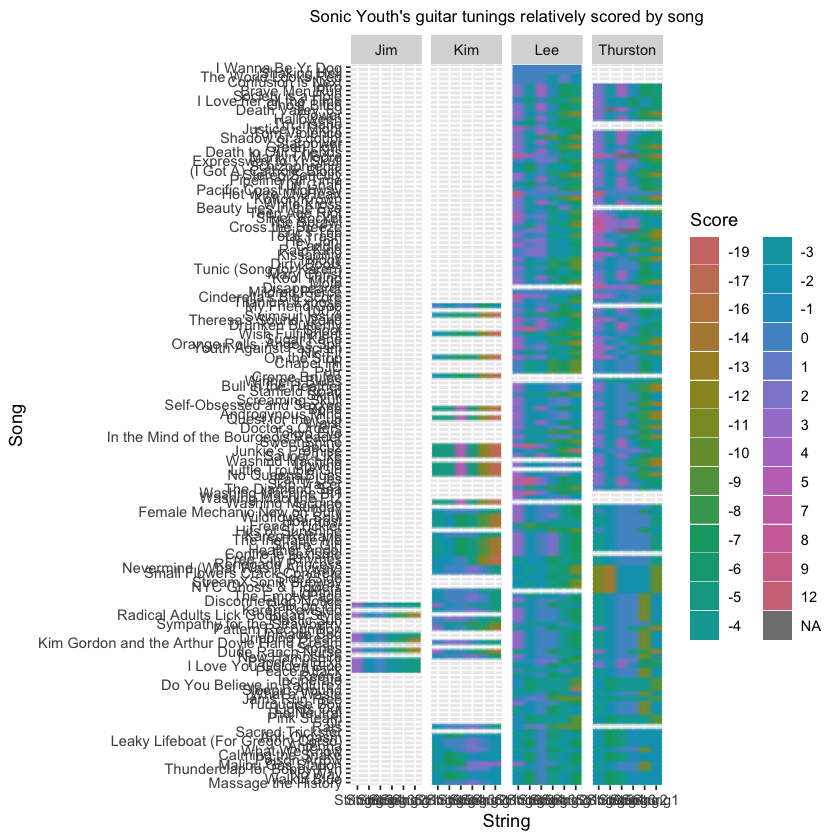

In [13]:
# colour mapped to tuning by song, facteted by name (scored)
tuningsOverCareer %>% 
    ggplot(aes(String, fct_rev(factor(Song, unique(data$Song))))) +
    geom_raster(aes(fill = factor(Score)), interpolate = TRUE) +
    scale_fill_hue(c=60,l=60, name = 'Score') +
    ylab('Song') +
    facet_grid(. ~ Name) +
    theme(plot.title = element_text(hjust = 0.5, size=10)) +
    ggtitle("Sonic Youth's guitar tunings relatively scored by song")

Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”

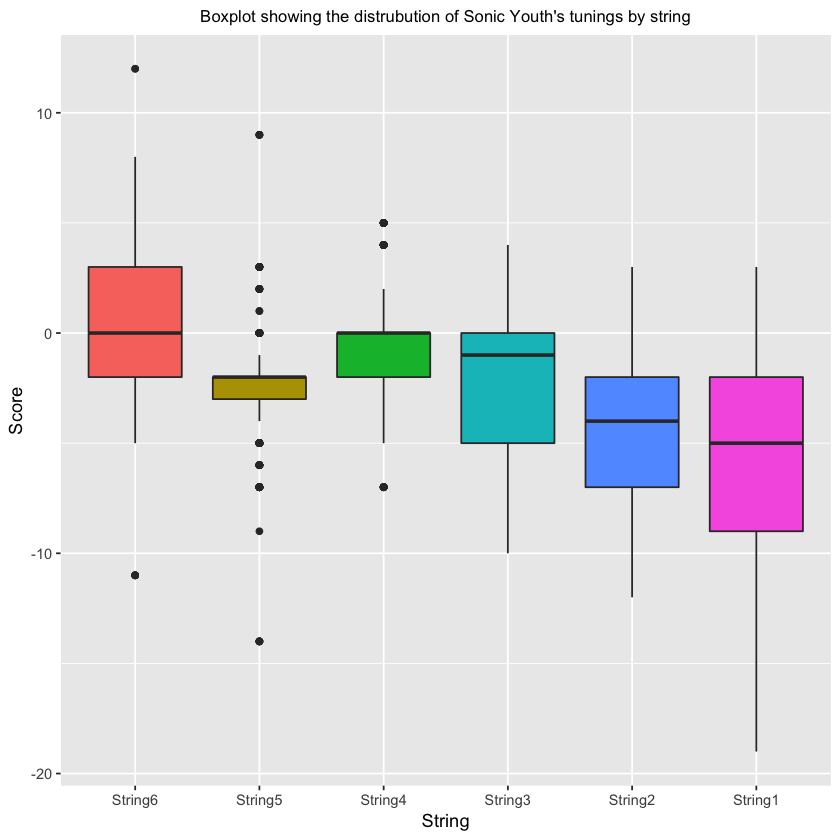

In [14]:
#########################################
# boxplot of tuning separated by string #
#########################################

tuningsOverCareer %>% 
    ggplot(aes(String, Score, fill=String)) +
    geom_boxplot() +
    theme(plot.title = element_text(hjust = 0.5, size=10),
          legend.position='none') +
    ggtitle("Boxplot showing the distrubution of Sonic Youth's tunings by string")

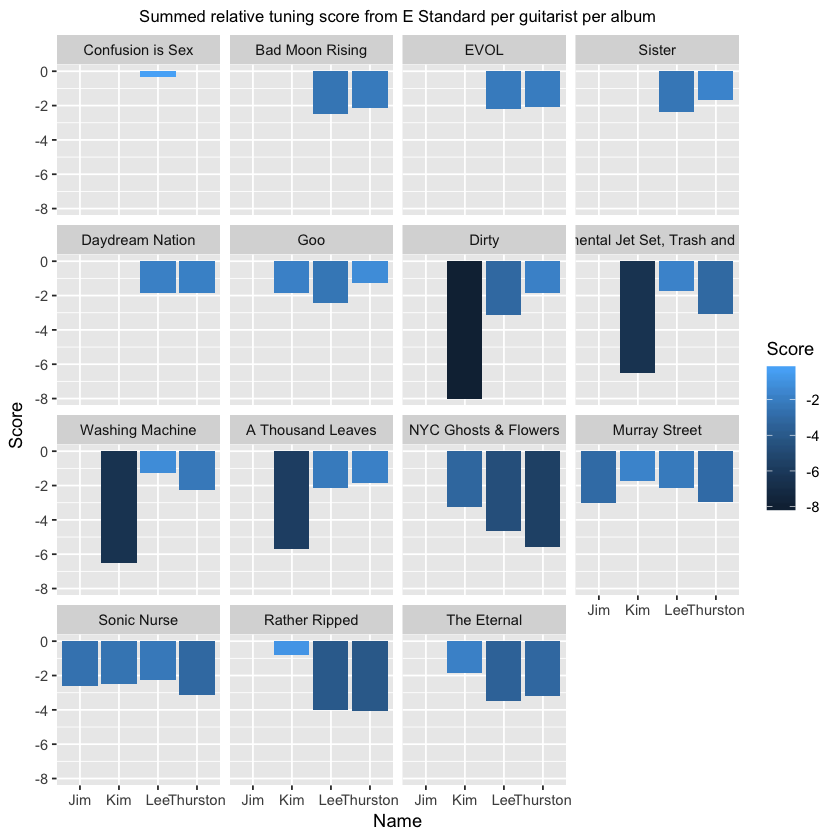

In [15]:
#############################################
# plot mean relative tuning score per album #
#############################################

# summed mean score of tunings by person/album    
tuningScoreSum <- tuningsOverCareer %>% 
    group_by(Name, Album) %>% 
    summarise_at(vars('Score'), mean, na.rm=TRUE)

# plot summed mean score by album
tuningScoreSum %>%
    ggplot(aes(Name, (Score), fill=(Score))) +
    geom_bar(stat='identity') +
    ylab('Score') +
    scale_fill_continuous(name='Score') +
    facet_wrap(~ factor(Album, unique(data$Album))) +
    theme(plot.title = element_text(hjust = 0.5, size=10)) +
    ggtitle('Summed relative tuning score from E Standard per guitarist per album')

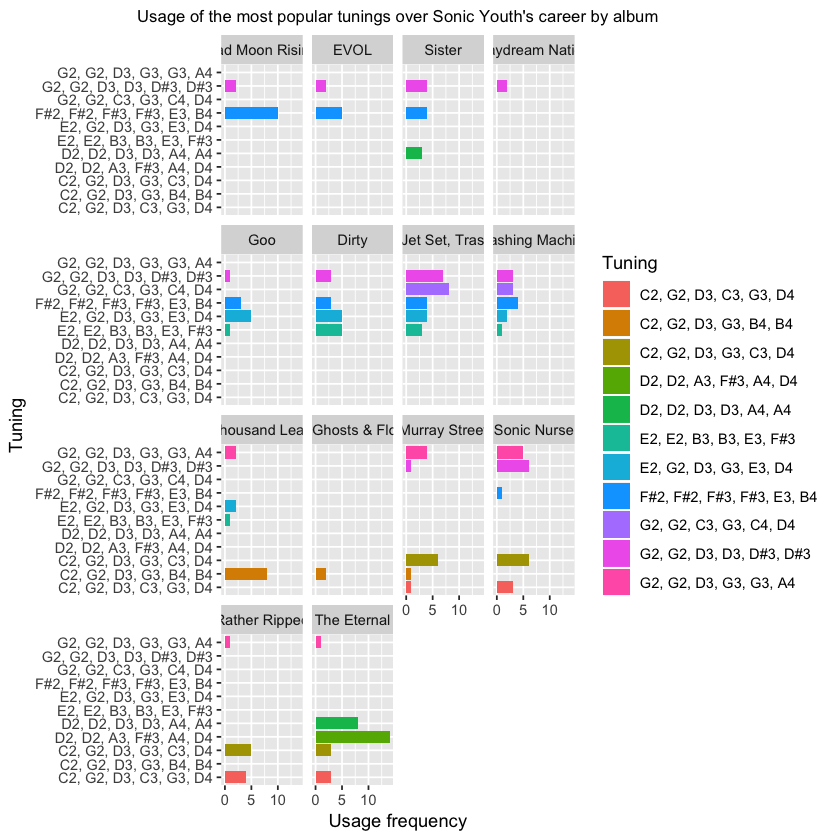

In [18]:
#############################################
# plot top 10 most popular tunings by album #
#############################################

# look at number of tunings used across each album
tuningsMoreThan10 <- tuningsCount %>% 
    arrange(-n) %>% 
    filter(n > 10) %>% 
    select(Tuning) %>% 
    pull()

popularTuningsByAlbum <- tuningsByAlbum %>% 
    filter(Tuning %in% tuningsMoreThan10) %>% 
    count(Album,Tuning)
    
popularTuningsByAlbum %>% 
    ggplot(aes(Tuning, n, fill=Tuning)) + 
    geom_bar(stat='identity') +
    facet_wrap(~ factor(Album, unique(data$Album))) +
    coord_flip() +
    theme(plot.title = element_text(hjust = 0.5, size=10)) +
    ggtitle('Usage of the most popular tunings over Sonic Youth\'s career by album') +
    ylab('Usage frequency')